In [1]:
%run Models.ipynb

# SHIR - Nelder-Mead

In [2]:
mod = []

for i,c in enumerate(countries):
    mod.append(Model(c, SHIR, time=None, start=starts[i]))
    print('\n')

Creating SHIR for Italy
Loaded country's population
Loaded time series of 146 days
Lockdown at 2020-03-11 -> at day 49
first VA index with lockdown: 17


Creating SHIR for Germany
Loaded country's population
Loaded time series of 141 days
Lockdown at 2020-03-20 -> at day 58
first VA index with lockdown: 21


Creating SHIR for Spain
Loaded country's population
Loaded time series of 143 days
Lockdown at 2020-03-14 -> at day 52
first VA index with lockdown: 17


Creating SHIR for United Kingdom
Loaded country's population
Loaded time series of 139 days
Lockdown at 2020-03-23 -> at day 61
first VA index with lockdown: 22




In [3]:
beta = 1.
mu = 0.05
I0 = 2e-10
sigma = 0.05

init_params = [beta, mu, I0, sigma]

In [4]:
for m in mod:
    m.fit(init_params)

Start fitting
End fitting
Results:
 final_simplex: (array([[ 9.74299945e-01,  4.64445201e-05,  8.68827610e-06,
         2.29546322e-01],
       [ 9.74327984e-01, -4.57744894e-05,  8.68599584e-06,
         2.29549524e-01],
       [ 9.74256130e-01, -7.63787546e-06,  8.69341772e-06,
         2.29544408e-01],
       [ 9.74231330e-01,  7.81328854e-07,  8.69699689e-06,
         2.29542930e-01],
       [ 9.74225326e-01, -2.99854733e-05,  8.69638204e-06,
         2.29540991e-01]]), array([0.00415507, 0.00415507, 0.00415507, 0.00415507, 0.00415507]))
           fun: 0.004155065398920988
       message: 'Optimization terminated successfully.'
          nfev: 579
           nit: 345
        status: 0
       success: True
             x: array([9.74299945e-01, 4.64445201e-05, 8.68827610e-06, 2.29546322e-01])
Start fitting
End fitting
Results:
 final_simplex: (array([[ 1.07123818e+00,  6.09029682e-05,  1.45586872e-06,
         2.33499433e-01],
       [ 1.07131861e+00, -2.15223306e-05,  1.45445635e-

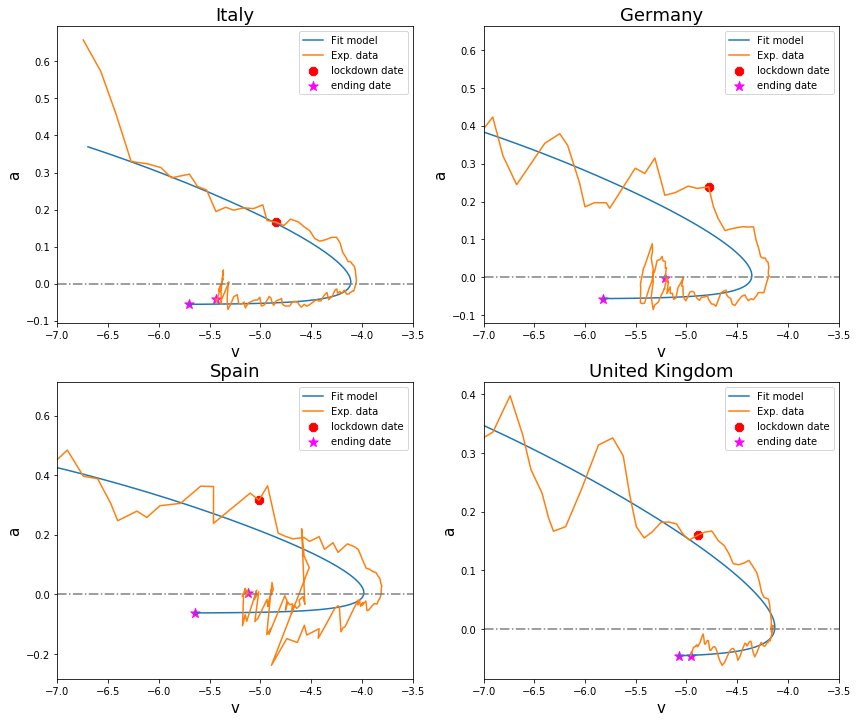

In [5]:
plt.figure(figsize=(14,12))

for i,m in enumerate(mod):
    plt.subplot(2,2,i+1)
    
    v, a = m.predict(m.optimal)
        
    plt.plot(v, a, label='Fit model')
    plt.scatter(v[-1], a[-1], 
                    c='magenta',marker='*',s=100,zorder=2)
    
    
    plt.plot(m.v_data, m.a_data, label='Exp. data')
    
    plt.scatter(m.v_data[m.lock_index-L-z], m.a_data[m.lock_index-L-z], 
                    c='red',marker='8',s=80, label='lockdown date')
    plt.scatter(m.v_data[-1], m.a_data[-1], 
                    c='magenta',marker='*',s=100,zorder=2, label='ending date')
    
    plt.xlim([-7., -3.5])
    plt.axhline(y=0, color='gray', linestyle='-.')
    plt.legend()
    plt.xlabel('v', size=15)
    plt.ylabel('a', size=15)
    plt.title(countries[i], size=18)

In [6]:
opt = []

for m in mod:
    opt.append(m.optimal)

opts = pd.DataFrame(opt, columns=['beta','mu','I0','sigma'], index=countries)
opts

,beta,mu,I0,sigma
Italy,0.949260,2.157093e-09,7.548614e-11,0.052692
Germany,1.147551,3.709172e-09,2.119554e-12,0.054522
Spain,1.475443,1.653611e-09,3.010252e-14,0.056051
United Kingdom,0.800820,1.139364e-09,8.069359e-11,0.044383


# Direct fit of acceleration

In [7]:
from scipy import optimize

In [8]:
cdict={'Germany':'#DDDD00',
       'Italy':'#11e0f0',
       'Spain':'red',
       'United Kingdom':'blue'}

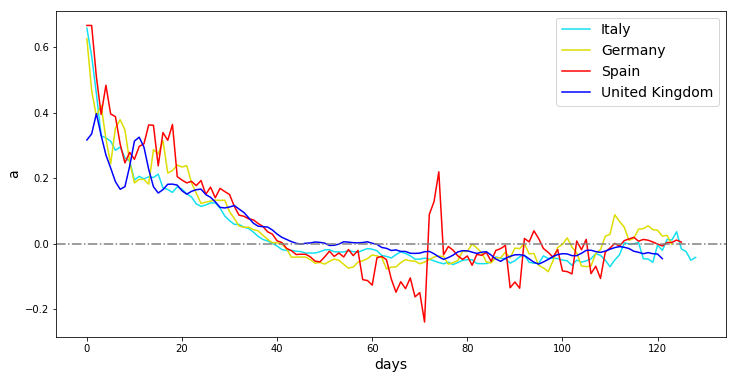

In [9]:
plt.figure(figsize=(12,6))

for i,m in enumerate(mod):
    plt.plot(range(m.T_va), m.a_data, c=cdict[countries[i]], label=countries[i])

plt.xlabel('days', size=14)
plt.ylabel('a', size=14)
plt.axhline(y=0, color='gray', linestyle='-.')
plt.legend(prop={'size': 14})
plt.show()

In [10]:
def func(t, b_eff, mu, sigma):
    return -(sigma + mu) + b_eff * np.exp(-sigma*t)

In [11]:
fits = []

for i,m in enumerate(mod):
    bounds=([0.,0.,0.],[np.inf,np.inf,np.inf])
    params, params_covariance = optimize.curve_fit(func, np.arange(m.T_va), m.a_data, bounds=bounds)
    fits.append(params)
    print(params)

[5.45768921e-01 5.45045149e-17 5.31476278e-02]
[5.41537721e-01 1.63326688e-18 4.89473485e-02]
[6.43767812e-01 5.26196730e-23 5.04319383e-02]
[0.40200231 0.0141053  0.03536704]


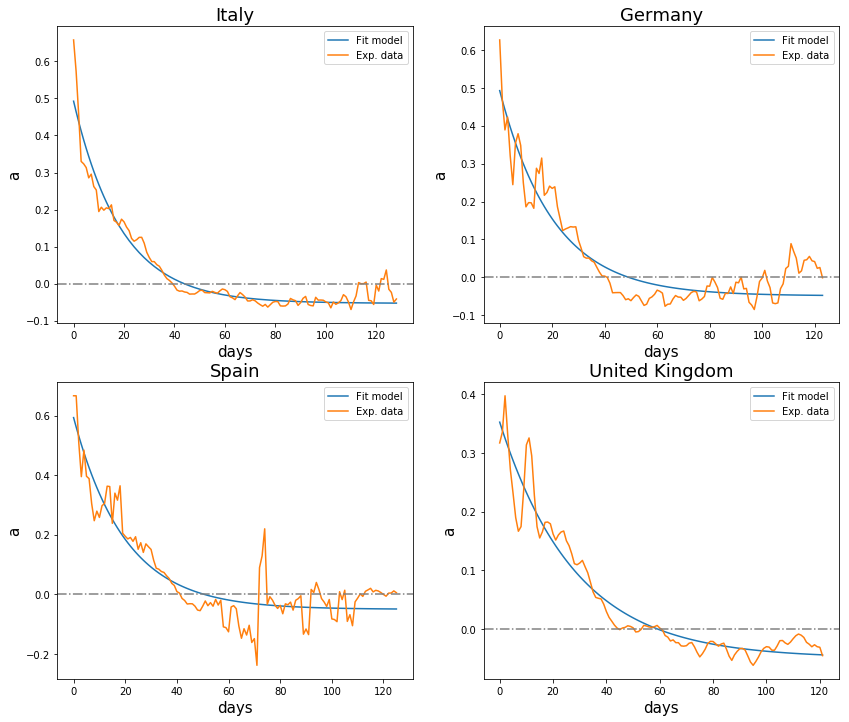

In [12]:
plt.figure(figsize=(14,12))

for i,m in enumerate(mod):
    plt.subplot(2,2,i+1)
    
    t = np.arange(m.T_va)
    plt.plot(t, func(t, fits[i][0], fits[i][1], fits[i][2]), label='Fit model')
    
    plt.plot(t, m.a_data, label='Exp. data')
    
    #plt.xlim([-7., -3.5])
    plt.axhline(y=0, color='gray', linestyle='-.')
    plt.legend()
    plt.xlabel('days', size=15)
    plt.ylabel('a', size=15)
    plt.title(countries[i], size=18)
    
plt.show()

In [13]:
opts1 = pd.DataFrame(fits, columns=['beta_eff', 'mu', 'sigma'], index=countries)
opts1

,beta_eff,mu,sigma
Italy,0.545769,5.450451e-17,0.053148
Germany,0.541538,1.633267e-18,0.048947
Spain,0.643768,5.261967e-23,0.050432
United Kingdom,0.402002,1.410530e-02,0.035367


# Fit only first 20 days

In [14]:
fits = []

for i,m in enumerate(mod):
    bounds=([0.,0.,0.],[np.inf,np.inf,np.inf])
    N = 20
    params, params_covariance = optimize.curve_fit(func, np.arange(N), m.a_data[:N], bounds=bounds)
    fits.append(params)
    print(params)

[5.97724636e-01 3.84990817e-13 6.51816286e-02]
[5.15594184e-01 8.33258896e-15 4.44069125e-02]
[5.99941225e-01 9.90567820e-16 4.30281098e-02]
[3.60891644e-01 2.71440005e-17 3.08606960e-02]


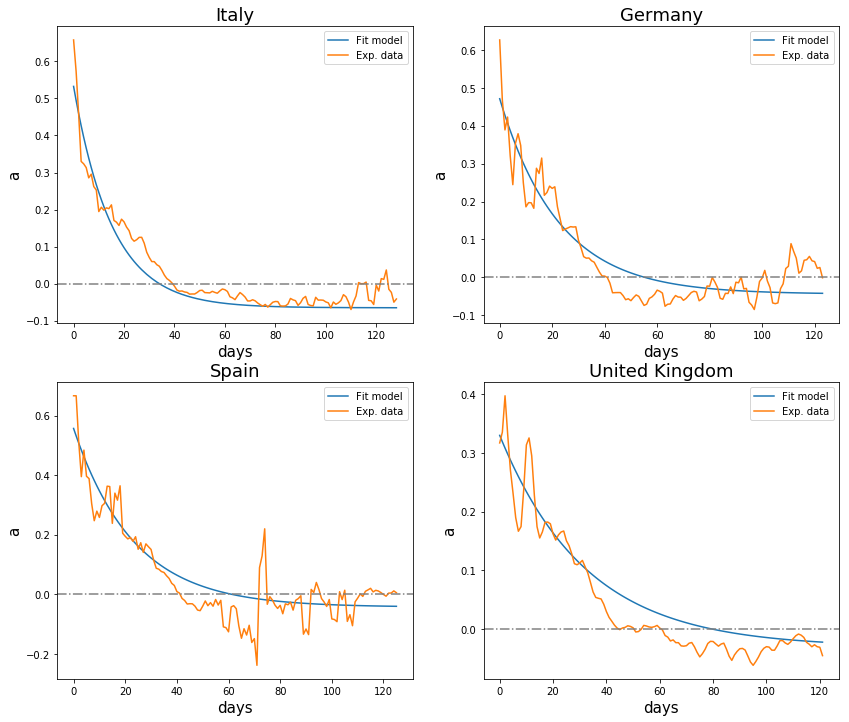

In [15]:
plt.figure(figsize=(14,12))

for i,m in enumerate(mod):
    plt.subplot(2,2,i+1)
    
    t = np.arange(m.T_va)
    plt.plot(t, func(t, fits[i][0], fits[i][1], fits[i][2]), label='Fit model')
    
    plt.plot(t, m.a_data, label='Exp. data')
    
    #plt.xlim([-7., -3.5])
    plt.axhline(y=0, color='gray', linestyle='-.')
    plt.legend()
    plt.xlabel('days', size=15)
    plt.ylabel('a', size=15)
    plt.title(countries[i], size=18)
    
plt.show()

In [16]:
opts2 = pd.DataFrame(fits, columns=['beta_eff', 'mu', 'sigma'], index=countries)
opts2

,beta_eff,mu,sigma
Italy,0.597725,3.849908e-13,0.065182
Germany,0.515594,8.332589e-15,0.044407
Spain,0.599941,9.905678e-16,0.043028
United Kingdom,0.360892,2.714400e-17,0.030861


# Mu fixed

In [17]:
def func_mu_fixed(t, b_eff, sigma):
    mu = 1./14.
    return -(sigma + mu) + b_eff * np.exp(-sigma*t)

In [18]:
fits = []

for i,m in enumerate(mod):
    bounds=([0.,0.],[np.inf,np.inf])
    params, params_covariance = optimize.curve_fit(func_mu_fixed, np.arange(m.T_va), m.a_data, bounds=bounds)
    fits.append(params)
    print(params)

[0.51698575 0.03258266]
[0.52840572 0.0313482 ]
[0.63315727 0.03445929]
[0.41213358 0.02386391]


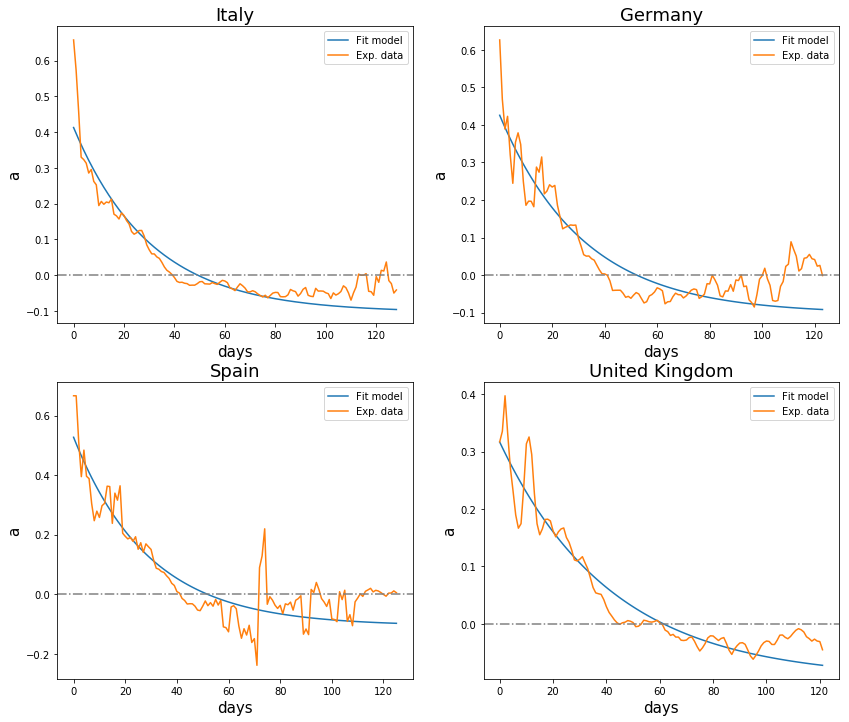

In [19]:
plt.figure(figsize=(14,12))

for i,m in enumerate(mod):
    plt.subplot(2,2,i+1)
    
    t = np.arange(m.T_va)
    plt.plot(t, func_mu_fixed(t, fits[i][0], fits[i][1]), label='Fit model')
    
    plt.plot(t, m.a_data, label='Exp. data')
    
    #plt.xlim([-7., -3.5])
    plt.axhline(y=0, color='gray', linestyle='-.')
    plt.legend()
    plt.xlabel('days', size=15)
    plt.ylabel('a', size=15)
    plt.title(countries[i], size=18)
    
plt.show()

In [20]:
opts3 = pd.DataFrame(fits, columns=['beta_eff', 'sigma'], index=countries)
opts3

,beta_eff,sigma
Italy,0.516986,0.032583
Germany,0.528406,0.031348
Spain,0.633157,0.034459
United Kingdom,0.412134,0.023864


# Mu fixed - first 20 days

In [21]:
fits = []

for i,m in enumerate(mod):
    bounds=([0.,0.],[np.inf,np.inf])
    N = 20
    params, params_covariance = optimize.curve_fit(func_mu_fixed, np.arange(N), m.a_data[:N], bounds=bounds)
    fits.append(params)
    print(params)

[0.6489107  0.05445243]
[0.57390314 0.03686906]
[0.65896378 0.03649974]
[0.42456864 0.0248089 ]


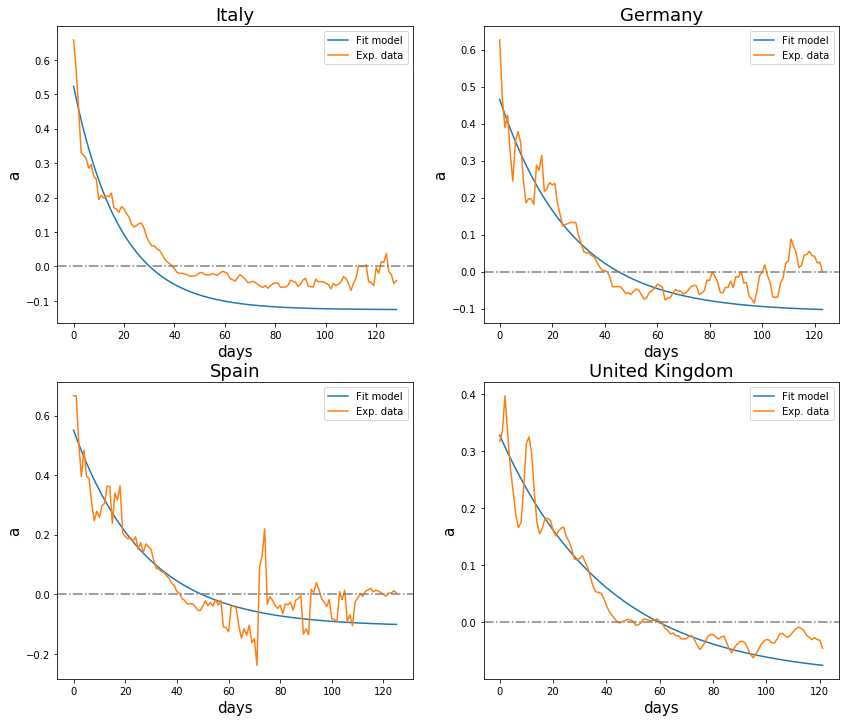

In [22]:
plt.figure(figsize=(14,12))

for i,m in enumerate(mod):
    plt.subplot(2,2,i+1)
    
    t = np.arange(m.T_va)
    plt.plot(t, func_mu_fixed(t, fits[i][0], fits[i][1]), label='Fit model')
    
    plt.plot(t, m.a_data, label='Exp. data')
    
    #plt.xlim([-7., -3.5])
    plt.axhline(y=0, color='gray', linestyle='-.')
    plt.legend()
    plt.xlabel('days', size=15)
    plt.ylabel('a', size=15)
    plt.title(countries[i], size=18)
    
plt.show()

In [23]:
opts4 = pd.DataFrame(fits, columns=['beta_eff', 'sigma'], index=countries)
opts4

,beta_eff,sigma
Italy,0.648911,0.054452
Germany,0.573903,0.036869
Spain,0.658964,0.036500
United Kingdom,0.424569,0.024809


# Comparison

In [27]:
print('DIFFERENT VALUES OF SIGMA')

tmp = pd.concat([opts['sigma'], opts1['sigma'], opts2['sigma'], opts3['sigma'], opts4['sigma']], axis=1,
          keys=['Nelder-Mead', 'Direct', 'Direct - 20 days', 'Mu fixed', 'Mu fixed - 20 days'])
tmp

DIFFERENT VALUES OF SIGMA


,Nelder-Mead,Direct,Direct - 20 days,Mu fixed,Mu fixed - 20 days
Italy,0.052692,0.053148,0.065182,0.032583,0.054452
Germany,0.054522,0.048947,0.044407,0.031348,0.036869
Spain,0.056051,0.050432,0.043028,0.034459,0.036500
United Kingdom,0.044383,0.035367,0.030861,0.023864,0.024809


In [26]:
print('DIFFERENT VALUES OF MU')

tmp = pd.concat([opts['mu'], opts1['mu'], opts2['mu']], axis=1,
                keys=['Nelder-Mead', 'Direct', 'Direct - 20 days'])
tmp

DIFFERENT VALUES OF MU


,Nelder-Mead,Direct,Direct - 20 days
Italy,2.157093e-09,5.450451e-17,3.849908e-13
Germany,3.709172e-09,1.633267e-18,8.332589e-15
Spain,1.653611e-09,5.261967e-23,9.905678e-16
United Kingdom,1.139364e-09,1.410530e-02,2.714400e-17
